## SNIC Algorithm and its improved version

In [9]:
import numpy as np
import cv2
import heapq
import matplotlib.pyplot as plt

In [10]:
class SNIC:
    def __init__(self, img, x_seg, y_seg):
        self.img_orig = img
        self.img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

        self.x_seg = x_seg
        self.y_seg = y_seg

        # Side of the square area arounnd coordinate centroid
        self.square_side = int(np.sqrt((self.img.shape[0]*self.img.shape[1])/(2*self.x_seg*self.y_seg)))

        # Padded version of the image for improved method
        if self.square_side%2 == 0 :
            pad2 = self.square_side//2
            pad1 = pad2-1
            self.img_padded = np.pad(self.img, ((pad1, pad2), (pad1, pad2), (0, 0)), 'symmetric')
        else :
            pad = self.square_side//2
            self.img_padded = np.pad(self.img, ((pad, pad), (pad, pad), (0, 0)), 'symmetric')

        # Generating seeds
        self.seeds = self.generate_seeds()

        # Binary matrix to keep track whether a pixel has alloted to a superpixel or not
        self.isAlloted = np.zeros((self.img.shape[0], self.img.shape[1]))

        # Label Matrix
        self.allotment_normal = np.zeros((img.shape[0], img.shape[1]), dtype='int')
        self.allotment_improved = np.zeros((img.shape[0], img.shape[1]), dtype='int')

        # Centroids
        self.centroids_normal = self.initialize_centroids()
        self.centroids_improved = self.initialize_centroids()

        # Number of pixels in each superpixel
        self.superpixelSize_normal = np.zeros(x_seg*y_seg)
        self.superpixelSize_improved = np.zeros(x_seg*y_seg)

        # Priority Queue
        self.Q = []
        heapq.heapify(self.Q)

        # Pushing all the seeds to queue
        self.push_seeds()

        # Generating superpixels
        self.generate_superpixels_normal()

        # Generatin superpixels in improved way
        self.generate_superpixels_improved()

    def reinitialize(self) :
        # Generating seeds
        self.seeds = self.generate_seeds()

        # Binary matrix to keep track whether a pixel has alloted to a superpixel or not
        self.isAlloted = np.zeros((self.img.shape[0], self.img.shape[1]))

        # Priority Queue
        self.Q = []
        heapq.heapify(self.Q)

        # Pushing all the seeds to queue
        self.push_seeds()

        return
    
    def generate_seeds(self) :
        seeds = []
        x_coords = np.linspace(0, self.img.shape[0]-1, self.x_seg).astype('int')
        y_coords = np.linspace(0, self.img.shape[1]-1, self.y_seg).astype('int')

        for x in x_coords :
            for y in y_coords :
                seeds.append((x, y))
        return seeds

    def initialize_centroids(self) :
        centroids = []

        for seed in self.seeds :
            centroids.append(np.array([ seed[0], seed[1], self.img[seed[0]][seed[1]][0], self.img[seed[0]][seed[1]][1], self.img[seed[0]][seed[1]][2] ]).astype('float'))
        return centroids

    def isValid(self, x, y, img) :
        if x>=0 and x<img.shape[0] and y>=0 and y<img.shape[1] and self.isAlloted[x][y] == 0 :
            return True
        else :
            return False

    def push_seeds(self) :
        for i, seed in enumerate(self.seeds) :
            seedX = seed[0]
            seedY = seed[1]
            seedl = self.img[seedX][seedY][0]
            seeda = self.img[seedX][seedY][1]
            seedb = self.img[seedX][seedY][2]
            seedPixel = self.Pixel(seedX, seedY, seedl, seeda, seedb, i, 0)
            heapq.heappush(self.Q, seedPixel)   

    def calculateD(self, pixelA, pixelB, coeff) :
        return (coeff*np.sum((pixelA[0:2]-pixelB[0:2])**2))+(np.sum((pixelA[2:]-pixelB[2:])**2)) 

    def allot_normal(self, x, y, k, detail) :
        self.allotment_normal[x][y] = k
        self.isAlloted[x][y] = 1

        newCentroid = ((self.centroids_normal[k]*self.superpixelSize_normal[k])+detail)/(self.superpixelSize_normal[k]+1)
        self.centroids_normal[k] = newCentroid

        self.superpixelSize_normal[k] += 1

    def calculate_color_centroid(self, coord_centroid) :
        # This method is only applicable for improved method
        x = int(coord_centroid[0])
        y = int(coord_centroid[1])

        mean_l = np.mean(self.img_padded[x:x+self.square_side, y:y+self.square_side, 0])
        mean_a = np.mean(self.img_padded[x:x+self.square_side, y:y+self.square_side, 1])
        mean_b = np.mean(self.img_padded[x:x+self.square_side, y:y+self.square_side, 2])

        return np.array([mean_l, mean_a, mean_b])

    def allot_improved(self, x, y, k, detail) :
        self.allotment_improved[x][y] = k
        self.isAlloted[x][y] = 1

        newCentroid = ((self.centroids_improved[k]*self.superpixelSize_improved[k])+detail)/(self.superpixelSize_improved[k]+1)
        newCentroid[2:] = self.calculate_color_centroid(newCentroid[0:2])

        self.centroids_improved[k] = newCentroid

        self.superpixelSize_improved[k] += 1

    def generate_superpixels_normal(self) :
        while(len(self.Q) > 0) :
            topPixel = heapq.heappop(self.Q)

            if self.isAlloted[topPixel.x][topPixel.y] == 0 :

                self.allot_normal(topPixel.x, topPixel.y, topPixel.k, topPixel.detail)

                # Adding 4 neighbors into the queue
                if(self.isValid(topPixel.x, topPixel.y+1, self.img)) :
                    D = self.calculateD(topPixel.detail, self.centroids_normal[topPixel.k], 1)
                    neighborPixel = self.Pixel(topPixel.x, topPixel.y+1, self.img[topPixel.x][topPixel.y+1][0], self.img[topPixel.x][topPixel.y+1][1], self.img[topPixel.x][topPixel.y+1][2], topPixel.k, D)
                    heapq.heappush(self.Q, neighborPixel)
                if(self.isValid(topPixel.x, topPixel.y-1, self.img)) :
                    D = self.calculateD(topPixel.detail, self.centroids_normal[topPixel.k], 1)
                    neighborPixel = self.Pixel(topPixel.x, topPixel.y-1, self.img[topPixel.x][topPixel.y-1][0], self.img[topPixel.x][topPixel.y-1][1], self.img[topPixel.x][topPixel.y-1][2], topPixel.k, D)
                    heapq.heappush(self.Q, neighborPixel)
                if(self.isValid(topPixel.x+1, topPixel.y, self.img)) :
                    D = self.calculateD(topPixel.detail, self.centroids_normal[topPixel.k], 1)
                    neighborPixel = self.Pixel(topPixel.x+1, topPixel.y, self.img[topPixel.x+1][topPixel.y][0], self.img[topPixel.x+1][topPixel.y][1], self.img[topPixel.x+1][topPixel.y][2], topPixel.k, D)
                    heapq.heappush(self.Q, neighborPixel)
                if(self.isValid(topPixel.x-1, topPixel.y, self.img)) :
                    D = self.calculateD(topPixel.detail, self.centroids_normal[topPixel.k], 1)
                    neighborPixel = self.Pixel(topPixel.x-1, topPixel.y, self.img[topPixel.x-1][topPixel.y][0], self.img[topPixel.x-1][topPixel.y][1], self.img[topPixel.x-1][topPixel.y][2], topPixel.k, D)
                    heapq.heappush(self.Q, neighborPixel)
        
        self.reinitialize()
        return

    def generate_superpixels_improved(self) :
        while(len(self.Q) > 0) :
            topPixel = heapq.heappop(self.Q)

            if self.isAlloted[topPixel.x][topPixel.y] == 0 :

                self.allot_improved(topPixel.x, topPixel.y, topPixel.k, topPixel.detail)

                # Adding 4 neighbors into the queue
                if(self.isValid(topPixel.x, topPixel.y+1, self.img)) :
                    D = self.calculateD(topPixel.detail, self.centroids_improved[topPixel.k], 1)
                    neighborPixel = self.Pixel(topPixel.x, topPixel.y+1, self.img[topPixel.x][topPixel.y+1][0], self.img[topPixel.x][topPixel.y+1][1], self.img[topPixel.x][topPixel.y+1][2], topPixel.k, D)
                    heapq.heappush(self.Q, neighborPixel)
                if(self.isValid(topPixel.x, topPixel.y-1, self.img)) :
                    D = self.calculateD(topPixel.detail, self.centroids_improved[topPixel.k], 1)
                    neighborPixel = self.Pixel(topPixel.x, topPixel.y-1, self.img[topPixel.x][topPixel.y-1][0], self.img[topPixel.x][topPixel.y-1][1], self.img[topPixel.x][topPixel.y-1][2], topPixel.k, D)
                    heapq.heappush(self.Q, neighborPixel)
                if(self.isValid(topPixel.x+1, topPixel.y, self.img)) :
                    D = self.calculateD(topPixel.detail, self.centroids_improved[topPixel.k], 1)
                    neighborPixel = self.Pixel(topPixel.x+1, topPixel.y, self.img[topPixel.x+1][topPixel.y][0], self.img[topPixel.x+1][topPixel.y][1], self.img[topPixel.x+1][topPixel.y][2], topPixel.k, D)
                    heapq.heappush(self.Q, neighborPixel)
                if(self.isValid(topPixel.x-1, topPixel.y, self.img)) :
                    D = self.calculateD(topPixel.detail, self.centroids_improved[topPixel.k], 1)
                    neighborPixel = self.Pixel(topPixel.x-1, topPixel.y, self.img[topPixel.x-1][topPixel.y][0], self.img[topPixel.x-1][topPixel.y][1], self.img[topPixel.x-1][topPixel.y][2], topPixel.k, D)
                    heapq.heappush(self.Q, neighborPixel)

        self.reinitialize()
        return

    def generate_adjescent_matrix(self, label_matrix, superpixelSize) :
        # Generating average L, a, b values for each superpixel

        # K is the total number of superpixels
        k = self.x_seg*self.y_seg

        color_means = np.zeros((k, 3), dtype='float')

        for i in range(k) :
            superpixel = np.zeros_like(self.img, dtype='float')
            superpixel[:, :, 0] = np.where(label_matrix == i, self.img[:, :, 0], 0)
            superpixel[:, :, 1] = np.where(label_matrix == i, self.img[:, :, 1], 0)
            superpixel[:, :, 2] = np.where(label_matrix == i, self.img[:, :, 2], 0)
            color_meansl = np.sum(superpixel[:, :, 0])/superpixelSize[i]
            color_meansa = np.sum(superpixel[:, :, 1])/superpixelSize[i]
            color_meansb = np.sum(superpixel[:, :, 2])/superpixelSize[i]
            color_means[i] = np.array([color_meansl, color_meansa, color_meansb])
        
        # generating the adjescent matrix
        adj_mat = np.zeros((k, k), dtype=float)

        for i in range(k) :
            j_arr = np.arange(i, k).astype('int')
            i_arr = np.full_like(j_arr, i)
            adj_mat[i, j_arr] = np.sum(np.abs(color_means[i_arr]-color_means[j_arr]), axis=1)
        
        return adj_mat

    
    def snic(self) :
        output_img = np.zeros_like(self.img)

        for i in range(output_img.shape[0]) :
            for j in range(output_img.shape[1]) :
                output_img[i][j] = self.centroids_normal[self.allotment_normal[i][j]][2:]

        output_img = cv2.cvtColor(output_img, cv2.COLOR_Lab2LRGB)        
        return output_img

    def snic_border(self) :
        output_img = np.full_like(self.img, np.array([255, 255, 255]))

        for i in range(output_img.shape[0]) :
            for j in range(output_img.shape[1]-1) :
                if self.allotment_normal[i][j] != self.allotment_normal[i][j+1] :
                    output_img[i][j] = np.array([0, 0, 0])

        for j in range(output_img.shape[1]) :
            for i in range(output_img.shape[0]-1) :
                if self.allotment_normal[i][j] != self.allotment_normal[i+1][j] :
                    output_img[i][j] = np.array([0, 0, 0])

        return self.img_orig&output_img

    def snic_edge(self) :
        adj_mat = self.generate_adjescent_matrix(self.allotment_normal, self.superpixelSize_normal)

        k = self.x_seg*self.y_seg

        # a_cap is the mean of all non-zero elements in the adjescent matrix
        a_cap = np.sum(adj_mat)/(((k**2)+k)/2)

        # Generating image with edge
        output_img = np.full_like(self.img, np.array([255, 255, 255]))

        for i in range(output_img.shape[0]) :
            for j in range(output_img.shape[1]-1) :
                if adj_mat[self.allotment_normal[i][j]][self.allotment_normal[i][j+1]] >= a_cap :
                    output_img[i][j] = np.array([0, 0, 0])

        for j in range(output_img.shape[1]) :
            for i in range(output_img.shape[0]-1) :
                if adj_mat[self.allotment_normal[i][j]][self.allotment_normal[i+1][j]] >= a_cap :
                    output_img[i][j] = np.array([0, 0, 0])

        return output_img


    def snic_improved(self) :
        output_img = np.zeros_like(self.img)

        for i in range(output_img.shape[0]) :
            for j in range(output_img.shape[1]) :
                output_img[i][j] = self.centroids_improved[self.allotment_improved[i][j]][2:]
        
        output_img = cv2.cvtColor(output_img, cv2.COLOR_Lab2LRGB)
        return output_img

    def snic_improved_border(self) :
        output_img = np.full_like(self.img, np.array([255, 255, 255]))

        for i in range(output_img.shape[0]) :
            for j in range(output_img.shape[1]-1) :
                if self.allotment_improved[i][j] != self.allotment_improved[i][j+1] :
                    output_img[i][j] = np.array([0, 0, 0])

        for j in range(output_img.shape[1]) :
            for i in range(output_img.shape[0]-1) :
                if self.allotment_improved[i][j] != self.allotment_improved[i+1][j] :
                    output_img[i][j] = np.array([0, 0, 0])

        return self.img_orig&output_img

    def snic_improved_edge(self) :
        adj_mat = self.generate_adjescent_matrix(self.allotment_normal, self.superpixelSize_normal)

        k = self.x_seg*self.y_seg

        # a_cap is the mean of all non-zero elements in the adjescent matrix
        a_cap = np.sum(adj_mat)/(((k**2)+k)/2)

        # Generating image with edge
        output_img = np.full_like(self.img, np.array([255, 255, 255]))

        for i in range(output_img.shape[0]) :
            for j in range(output_img.shape[1]-1) :
                if adj_mat[self.allotment_improved[i][j]][self.allotment_improved[i][j+1]] >= a_cap :
                    output_img[i][j] = np.array([0, 0, 0])

        for j in range(output_img.shape[1]) :
            for i in range(output_img.shape[0]-1) :
                if adj_mat[self.allotment_improved[i][j]][self.allotment_improved[i+1][j]] >= a_cap :
                    output_img[i][j] = np.array([0, 0, 0])

        return output_img

    # Defining Pixel Model to push into the queue
    class Pixel:
        def __init__(self, x, y, l, a, b, k, D):
            self.x = x
            self.y = y
            self.l = l
            self.a = a
            self.b = b
            self.k = k
            self.D = D
            self.detail = np.array([x, y, l, a, b])
    
        def __lt__(self, nxt):
            return self.D < nxt.D


In [11]:
img = cv2.imread('./Lenna.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [15]:
snic = SNIC(img, 30, 30)

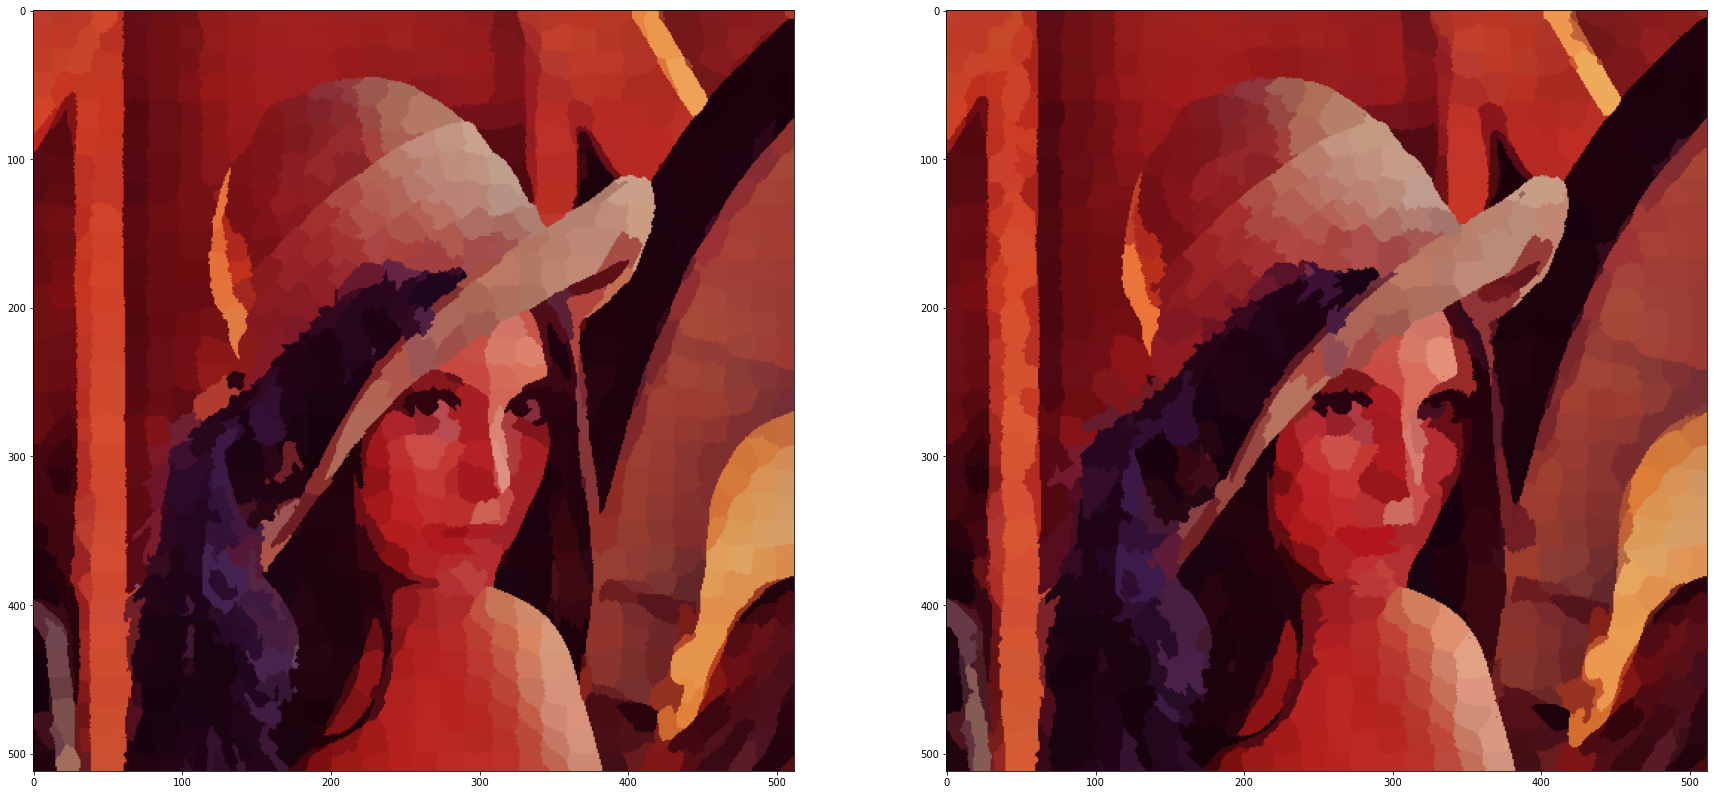

In [16]:
plt.figure(figsize=[30, 30])
plt.subplot(1, 2, 1)
plt.imshow(snic.snic())
plt.subplot(1, 2, 2)
plt.imshow(snic.snic_improved())

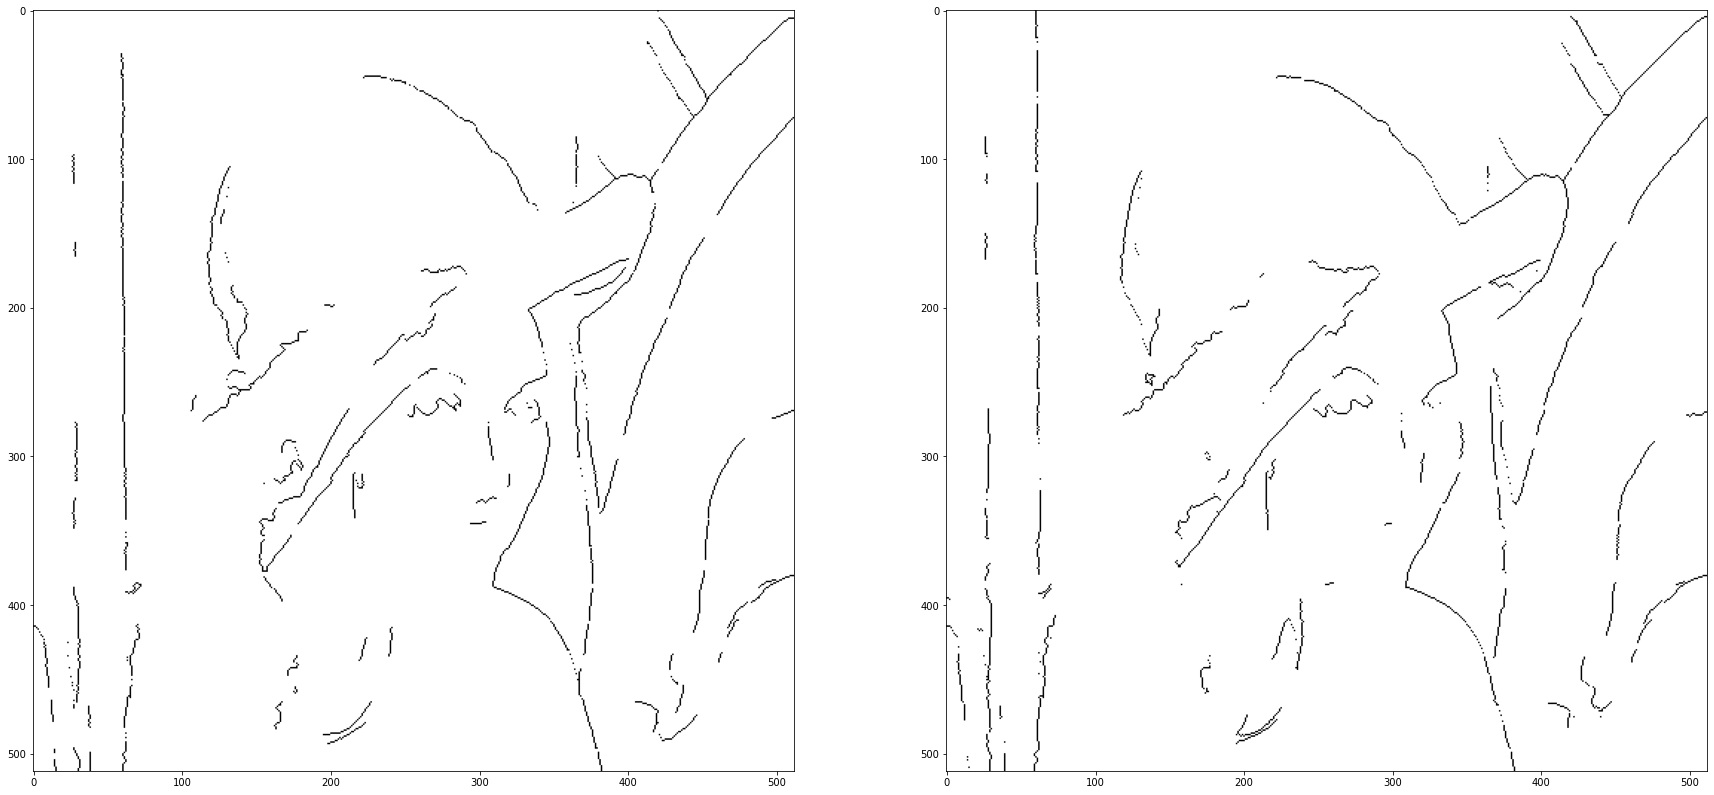

In [17]:
plt.figure(figsize=[30, 30])
plt.subplot(1, 2, 1)
plt.imshow(snic.snic_edge())
plt.subplot(1, 2, 2)
plt.imshow(snic.snic_improved_edge())